In [38]:
# import all tools needed
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# for plotting consistently with abu_profile
from nugridpy import utils as u

# use h5py to read and write h5 file
import h5py

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [39]:
# read in the 2M kippenhahn diagram
star2 = ms.star_log(mass=2.0,Z=0.02)

# grab post processing from mesa model
path = '/user/ast501/dstephens/mppnp/diffusion_mesa/mppnp_subtime_0/H5_out/'
star2_pp = mp.se(mass=2.0,Z=0.02)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 

Closing star.log  tool ...
nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Searching files, please wait.......
Reading preprocessor files
File search complete.
Closing plot_tools


## 13C Pocket

<IPython.core.display.Javascript object>


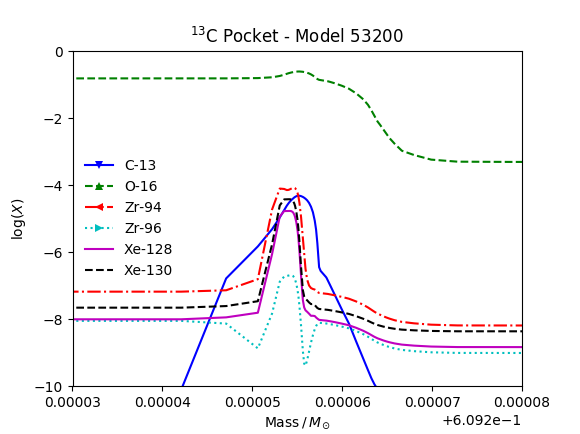

 reading ['iso_massf']...100%

In [40]:
# list of species to look at
species = ['C-13','O-16','Zr-94','Zr-96','Xe-128','Xe-130']
pocket_num = 53200

# create abundance plot
fig = plt.figure(6)
fig.set_size_inches(5.8,4.35)
star2_pp.abu_profile(isos=species,ifig=6,fname=pocket_num,logy=True)

# limits
plt.ylim([-10,0])
plt.xlim([0.60923,0.60928])

# put title 
plt.title(r'$^{13}$C Pocket - Model ' + str(pocket_num))

# grab the ylimits of C13 pocket
c13_lim = [0.609246,0.609258]

# save figure
fig.savefig('C13 Pocket.png')

## Kippenhahn

<IPython.core.display.Javascript object>


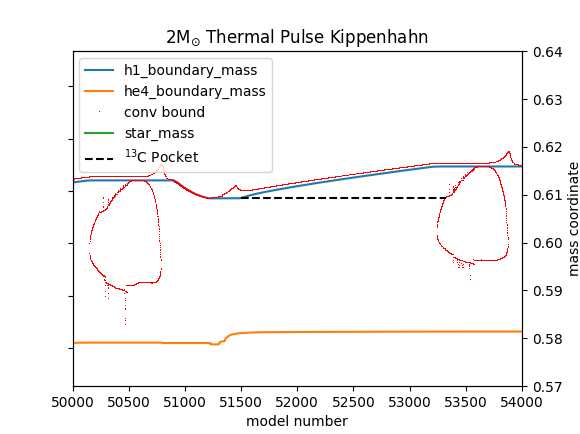

In [41]:
fig = plt.figure(1)
star2.kippenhahn_CO(1,'model')
fig.set_size_inches(5.8,4.35)

# limits to view
plt.xlim([50000,54000])
plt.ylim([0.57,0.64])

# get all axes objects
axes1, axes2 = fig.get_axes()

# turn off axes1 (CO ratio)
axes1.get_legend().remove()
axes1.get_lines().pop(0).remove()
axes1.set_ylabel('')
axes1.set_yticklabels([])

# turn on title
axes2.set_title(r'2M$_{\odot}$ Thermal Pulse Kippenhahn')

# add c13 pocket make it a line
model_num = np.linspace(51500,53320,1000)
c13_mass = c13_lim[0] * np.ones(len(model_num))
axes2.plot(model_num,c13_mass,'k--',label=r'$^{13}$C Pocket')

handles, labels = axes2.get_legend_handles_labels()
axes2.legend(handles,labels)

# axes2.add_patch(patches.Rectangle((51500,c13_lim[0]),2000,(c13_lim[1]-c13_lim[0])))
# save the figure
fig.savefig('2M_Kippenhahn.png')

## Neutron Density

In [42]:
# function to find the maximum extent of convection zone as well as the average extent
def avg_mass_bounds(star,model_range):
    # just need the star objects, and the model range that the convection zone is contained in

    # get the mass ranges of convection boundary
    star_mass = star.get('star_mass')[model_range[0]:model_range[1]]
    mix_low = star.get('mx2_bot')[model_range[0]:model_range[1]]
    mix_high = star.get('mx2_top')[model_range[0]:model_range[1]]
    
    # find where they are zero or not
    convection_bounds = []
    for i in range(len(star_mass) - 1):
        
        # make sure that there is convection and that the next element doesnt stop
        if mix_low[i] >= 1e-9 and mix_low[i+1] >= 1e-9:
            convection_bounds.append(i)
            
    # slice the arrays to the appropriate size
    star_mass = star_mass[convection_bounds[0]:(convection_bounds[-1] + 1)]
    mix_low = mix_low[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    mix_high = mix_high[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    
    # make sure that if there
    
    # return the max convection bounds as well as average AND new model range
    max_bounds = [min(mix_low),max(mix_high)]
    avg_bounds = [np.mean(mix_low),np.mean(mix_high)]
    model_range = [model_range[0] + convection_bounds[0], model_range[0] + convection_bounds[-1]]
    
    return max_bounds, avg_bounds, model_range

In [43]:
# read in the data
data = np.genfromtxt('/user/david/github/Astr501/David Project/Mg25 Activation/2M_Average.txt',delimiter=',',comments='#',unpack=True)

# grab the neutron density, mass, and temperature
models = data[0]
temperature = data[2]
neutron_d = data[3]

# convert to number density
neutron_mass = 1.674929e-27 * 1e3
neutron_d = neutron_d / neutron_mass

max_bounds, avg_bounds, model_range = avg_mass_bounds(star2,[int(models[0]),int(models[-1])])

# get the log dt time steps and use for time since first model
log_dt = star2.get('log_dt')[int(models[0]):(int(models[-1])+1)]

# make a sum
dt = np.zeros(len(log_dt))
sum_dt = 0
for i in range(len(log_dt)):
    if i != 0:
        sum_dt += 10**(log_dt[i]) 
    dt[i] = sum_dt

<IPython.core.display.Javascript object>


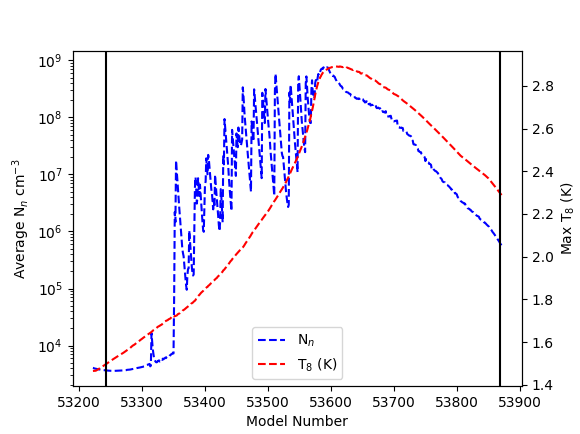

In [44]:
# plot
fig = plt.figure(2)
fig.set_size_inches(5.8,4.35)

# get axis
ax1 = fig.add_subplot(111)

# plot
lns1 = ax1.semilogy(models,neutron_d,'b--',label=r'N$_{n}$')
ax1.set_ylabel(r'Average N$_{n}$ cm$^{-3}$')
ax1.set_xlabel('Model Number')

# second axis
ax2 = ax1.twinx()

# plot
lns2 = ax2.plot(models,temperature / 1e8,'r--',label=r'T$_{8}$ (K)')
ax2.set_ylabel('Max T$_{8}$ (K)')

# add axes lines together for legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=8)

# vertical lines for start and end of convection
ax2.axvline(model_range[0],color='k',linestyle='-')
ax2.axvline(model_range[-1],color='k',linestyle='-')

# save figure
fig.savefig('Neutron_Density.png')

<IPython.core.display.Javascript object>


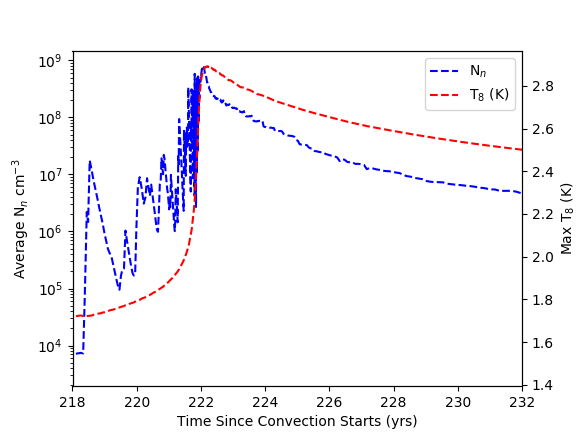

In [45]:
# plot
fig = plt.figure(3)
fig.set_size_inches(5.8,4.35)

# get axis
ax1 = fig.add_subplot(111)

# plot
lns1 = ax1.semilogy(dt,neutron_d,'b--',label=r'N$_{n}$')
ax1.set_ylabel(r'Average N$_{n}$ cm$^{-3}$')
ax1.set_xlabel('Time Since Convection Starts (yrs)')
ax1.set_xlim([218,232])

# second axis
ax2 = ax1.twinx()

# plot
lns2 = ax2.plot(dt,temperature / 1e8,'r--',label=r'T$_{8}$ (K)')
ax2.set_ylabel('Max T$_{8}$ (K)')
ax2.set_xlim([218,232])
# add axes lines together for legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

# vertical lines for start and end of convection
ax2.axvline(dt[0],color='k',linestyle='-')
ax2.axvline(dt[-1],color='k',linestyle='-')

# save figure
fig.savefig('Neutron_Density_Time.png')

## Zr Isotopic Ratios

In [46]:
# get the isoabund plots befor
cycle_c13 = 53200

# the mass range is the min_max_bounds

# get the isoabund plots after
cycle_after = 53880

<IPython.core.display.Javascript object>


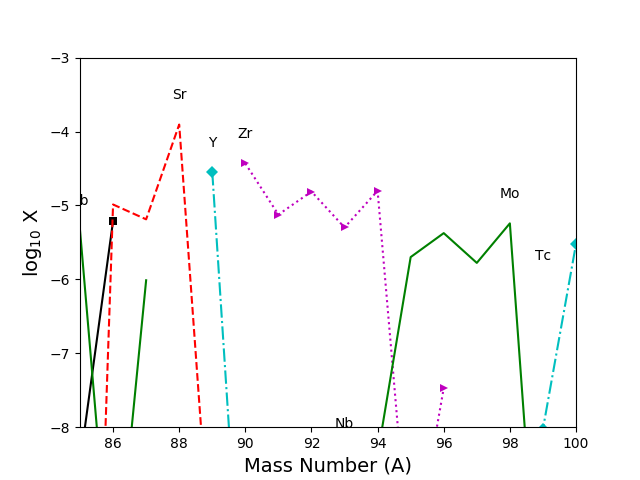

 reading ['mass']...100%Using the following conditions:
	mass_range: 0.609246 0.609258
	Atomic mass_range: 1 210
	cycle:            0000053200
	plot only stable: False
	plot decayed:     False


In [47]:
# plot the c13 ratios
fig = plt.figure(98)
star2_pp.iso_abund(cycle=cycle_c13,mass_range=c13_lim)

axes = fig.get_axes()
axes[0].set_ylabel(r'log$_{10}$ X')
axes[0].set_xlabel('Mass Number (A)')

# set limits
axes[0].set_ylim([-8,-3])
axes[0].set_xlim([85,100])

# savefig
fig.savefig('C13_Zr.png')

<IPython.core.display.Javascript object>


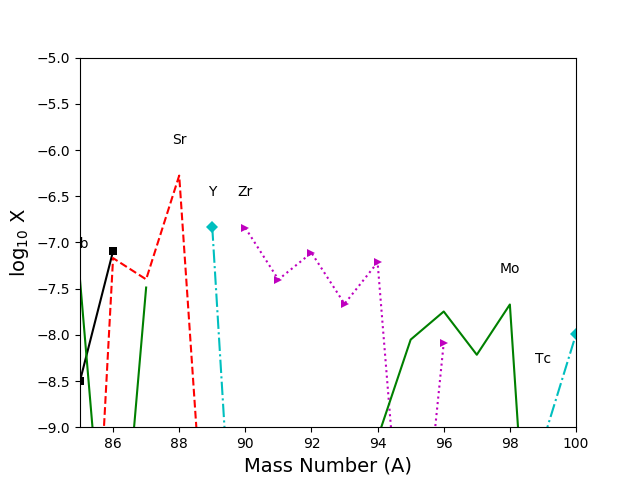

 reading ['mass']...100%Using the following conditions:
	mass_range: 0.592142944069 0.615784223024
	Atomic mass_range: 1 210
	cycle:            0000053880
	plot only stable: False
	plot decayed:     False


In [48]:
# plot the c13 ratios
fig = plt.figure(187)
star2_pp.iso_abund(cycle=cycle_after,mass_range=max_bounds)

axes = fig.get_axes()
axes[0].set_ylabel(r'log$_{10}$ X')
axes[0].set_xlabel('Mass Number (A)')

# set limits
axes[0].set_ylim([-9,-5])
axes[0].set_xlim([85,100])

# save figure
fig.savefig('Pulse_Zr.png')

## Mg25 production

In [ ]:
# use the data array, grab rho Mg25 and avg volume
rho_mg = data[4]
volume = data[1]
models = data[0]

# get the magnesium production factor
mg0 = rho_mg[0] * volume[0] * (6.95e8 * 1e2)**3 
mg_production = []
for i in range(len(models)):
    mg_production.append((rho_mg[i] * volume[i] * (6.95e8 * 1e2)**3 - mg0) / mg0)

# make the plot
fig = plt.figure(172)
plt.plot(dt,mg_production)
# plt.axvline(dt[0],color='k',linestyle='-')

# labels
plt.xlabel('Time Since Convection Starts (yrs)')
plt.ylabel(r'$^{25}$Mg Production')

# save
fig.savefig('mesa_production.png')

## Temperature and mass coordinate

In [ ]:
# function to find the nearest mass element index to a particular mass
def find_mass_index(star_pp,model,mass_interest):
    
    # check if model is a list of multiple stars to look through
    if type(model) == float or type(model) == int:
        model = [model]
        iterate = len(model)
    else:
        iterate = len(model)
    
    # check if mass interest is a list or not
    mass_bool = 0
    if type(mass_interest) == float or type(mass_interest) == int:
        mass_bool = 0
    else:
        mass_bool = 1 
    
    # create a np array to hold the mass index
    mass_index = np.zeros((iterate))
    
    # iterate through
    for i in range(iterate):
        
        # read in the mass array
        mass = star_pp.se.get(int(model[i]),'mass')
        
        # is mass interest a list
        if mass_bool:
            mass_index[i] = int(np.argmin(abs(mass_interest[i] - mass)))
        else:
            mass_index[i] = int(np.argmin(abs(mass_interest[i] - mass)))
    
    # return the mass index array
    return mass_index

The non subtime plots to highlight relationship, then show differences in sub time stepping for resolving features

In [ ]:
# grab the .se.h5 files containing the data needed
path_file = '/user/ast501/dstephens/mppnp/diffusion_changes/diffusion_jones/mppnp_subtime_0/H5_out/M2.00Z0.020.0053501.out.h5'

data_file = h5py.File(path_file)

# model number
model = 53590

# cycle to work with is at highest T, 53700
data_group = data_file['cycle00000'+str(model)]['SE_DATASET']

mass = np.flip(data_group['mass'],0)
diffusion = np.flip(data_group['dcoeff'],0)
temperature_h5 = np.flip(data_group['temperature'],0) * 1e1
rho = np.flip(data_group['rho'],0)

# get the mixing ranges
mx_bot = star2.get('mx2_bot')[model-1] * star2.get('star_mass')[model-1]
mx_top = star2.get('mx2_top')[model-1] * star2.get('star_mass')[model-1]

In [ ]:
# find the index number for the mass
bot_index = np.argmin(abs(mass - mx_bot))
top_index = np.argmin(abs(mass - mx_top))

# get the iso_massf data for neutron density
iso_massf = np.flip(data_group['iso_massf'],0)

# neutron is just one of them
neutron = iso_massf[:,0] * rho

# get the volume
# avg_volume = (4/3.) * np.pi * (radius[top_index]**3 - radius[bot_index]**3)

# get neutron density
neutron = (neutron) / neutron_mass

# use the temperature profile from model number 53700
fig = plt.figure(183)
# fig.set_size_inches(5.8,4.35)
ax = fig.add_subplot(111)

# plot T as a function of mass, use schwarz bounds
lns1 = ax.semilogy(mass,temperature_h5,'r-',label='T$_{8}$')

# add schwarz boundaries
ax.axvline(mass[bot_index],color='k',linestyle='-',label='Schwarz Boundary')
ax.axvline(mass[top_index],color='k',linestyle='-')

# set limits
ax.set_xlim([0.595,0.616])
ax.set_ylim([1e-1,5])
ax.set_xlabel(r'Mass (M / M$_{\odot}$)')
ax.set_ylabel(r'T$_{8}$ (K)')

# set title
plt.title('T$_{8}$ and N$_{n}$ - Model '+str(model))

# add new axis
ax2 = ax.twinx()

lns3 = ax2.semilogy(mass,neutron,'b--',label=r'N$_{n}$')

# set limits
ax2.set_xlim([0.595,0.616])
ax2.set_ylim([1e6,2e9])
ax2.set_xlabel(r'Mass (M / M$_{\odot}$)')
ax2.set_ylabel(r'N$_{n}$ cm$^{-3}$')

# add axes lines together for legend
lns = lns1+lns3 
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

# save fig
fig.savefig('T_Neutron.png')

In [ ]:
# grab the .se.h5 files containing the data needed
path_file = '/user/ast501/dstephens/mppnp/diffusion_changes/diffusion_jones/mppnp_subtime_100/H5_out/M2.00Z0.020.0053621.out.h5'
path_file2 = '/user/ast501/dstephens/mppnp/diffusion_changes/diffusion_jones/mppnp_subtime_0/H5_out/M2.00Z0.020.0053501.out.h5'

data_file = h5py.File(path_file)
data_file2 = h5py.File(path_file2)

# model number
model = 53622

# cycle to work with is at highest T, 53700
data_group = data_file['cycle00000'+str(model)]['SE_DATASET']
data_group2 = data_file2['cycle00000'+str(model)]['SE_DATASET']

mass = np.flip(data_group['mass'],0)
diffusion = np.flip(data_group['dcoeff'],0)
temperature_h5 = np.flip(data_group['temperature'],0) * 1e1
rho = np.flip(data_group['rho'],0)

mass2 = np.flip(data_group2['mass'],0)
diffusion2 = np.flip(data_group2['dcoeff'],0)
temperature_h52 = np.flip(data_group2['temperature'],0) * 1e1
rho2 = np.flip(data_group2['rho'],0)

# get the mixing ranges
mx_bot = star2.get('mx2_bot')[model-1] * star2.get('star_mass')[model-1]
mx_top = star2.get('mx2_top')[model-1] * star2.get('star_mass')[model-1]

In [ ]:
# find the index number for the mass
bot_index = np.argmin(abs(mass - mx_bot))
top_index = np.argmin(abs(mass - mx_top))

# get the iso_massf data for neutron density
iso_massf = np.flip(data_group['iso_massf'],0)
iso_massf2 = np.flip(data_group2['iso_massf'],0)

# neutron is just one of them
neutron = iso_massf[:,0] * rho
neutron2 = iso_massf2[:,0] * rho2

# get the volume
# avg_volume = (4/3.) * np.pi * (radius[top_index]**3 - radius[bot_index]**3)

# get neutron density
neutron = (neutron) / neutron_mass
neutron2 = neutron2 / neutron_mass

# use the temperature profile from model number 53700
fig = plt.figure(182)
# fig.set_size_inches(5.8,4.35)
ax = fig.add_subplot(111)

# plot T as a function of mass, use schwarz bounds
lns1 = ax.semilogy(mass,temperature_h5,'r-',label='T$_{8}$')

# add schwarz boundaries
ax.axvline(mass[bot_index],color='k',linestyle='-',label='Schwarz Boundary')
ax.axvline(mass[top_index],color='k',linestyle='-')

# set limits
ax.set_xlim([0.595,0.616])
ax.set_ylim([1e-1,5])
ax.set_xlabel(r'Mass (M / M$_{\odot}$)')
ax.set_ylabel(r'T$_{8}$ (K)')

# set title
plt.title('T$_{8}$ and Subtime N$_{n}$ - Model '+str(model))
# add new axis
ax2 = ax.twinx()

lns3 = ax2.semilogy(mass,neutron,'b--',label=r'N$_{n}$ subtime=100')
lns2 = ax2.semilogy(mass2,neutron2,'g--',label=r'N$_{n}$ subtime=0')

# set limits
ax2.set_xlim([0.595,0.616])
ax2.set_ylim([1e7,1e10])
ax2.set_xlabel(r'Mass (M / M$_{\odot}$)')
ax2.set_ylabel(r'N$_{n}$ cm$^{-3}$')

# add axes lines together for legend
lns = lns1+lns3 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

# save fig
fig.savefig('T_Neutron_sub.png')

## Diffusion Coefficient Changes

In [ ]:
path_mesa = '/user/ast501/dstephens/mppnp/diffusion_mesa/mppnp_subtime_0/H5_out/M2.00Z0.020.0053501.out.h5'
path_jones = '/user/ast501/dstephens/mppnp/diffusion_changes/diffusion_jones/mppnp_subtime_0/H5_out/M2.00Z0.020.0053501.out.h5'

# open the h5 files
h5_mesa = h5py.File(path_mesa)
h5_jones = h5py.File(path_jones)

# cycle number
cycle_num = 53520

# find where the last model is, and make the string for cycle
cycle_model_end = 'cycle00000' + str(cycle_num)

mesa_diffusion = np.flip(h5_mesa[cycle_model_end]['SE_DATASET']['dcoeff'],0)
mass = np.flip(h5_mesa[cycle_model_end]['SE_DATASET']['mass'],0)

jones_diffusion = np.flip(h5_jones[cycle_model_end]['SE_DATASET']['dcoeff'],0)

In [ ]:
# make plot of last diffusion coefficient found
fig = plt.figure(64)
plt.semilogy(mass,(mesa_diffusion),label='Mesa D')
plt.semilogy(mass,(jones_diffusion),label='Jones D')
# plt.plot(mass_h5,np.log10(modified_diffusion_h5),label='h5 diffusion data')

# limits
plt.xlim([0.594,0.616])
plt.ylim([1e5,1e15])

# labels
plt.xlabel('Mass (M / M$_\odot$)')
plt.ylabel('D (cm$^{2}$ s$^{-1}$)')

plt.legend()

# save fig
fig.savefig('Diffusion_compare.png')

## Convective Time Scale

In [ ]:
# for the mesa model data, get the convective time scale for every model that has convection
path_file = '/data/nugrid_apod2/data/set1ext/set1.2/see_wind/M2.00Z2.0e-02/M2.00Z0.020/M2.00Z0.020.0053001.se.h5'

# alpha
alpha = 1.73

# grab the mixing spots
star_mass = star2.get('star_mass')[(int(models[0])-1):int(models[-1])]
mix_bot = star2.get('mx2_bot')[(int(models[0])-1):int(models[-1])] * star_mass
mix_top = star2.get('mx2_top')[(int(models[0])-1):int(models[-1])] * star_mass
dt_step = star2.get('log_dt')[(int(models[0])-1):int(models[-1])]

# rescale dt_step
dt_step = 10**(dt_step) * 365.25 * 24

time_scale = []

data_file = h5py.File(path_file)

# loop through
for i in range(len(models)):
    
    if mix_bot[i] <= 1e-4:
        time_scale.append(0)
        pass
    else:
        # grab the pressure, dcoeff, and radius
        pressure = np.flip(data_file['cycle00000' + str(int(models[i]))]['SE_DATASET']['pressure'],0)
        dcoeff = star2_pp.get(int(models[i]),'dcoeff')
        radius = star2_pp.get(int(models[i]),'radius')

        # get the schwarz boundaries
        schwarz_bot = int(find_mass_index(star_pp=star2_pp,model=int(models[i]),mass_interest=[mix_bot[i]])[0])
        schwarz_top = int(find_mass_index(star_pp=star2_pp,model=int(models[i]),mass_interest=[mix_top[i]])[0])

        # get Hp
        Hp = - pressure[schwarz_bot] * (radius[schwarz_bot + 1] - radius[schwarz_bot]) / (pressure[schwarz_bot + 1] - pressure[schwarz_bot])

        # convert hp to cm
        Hp *= 6.95e8 * 1e2
        mixing_length = alpha * Hp

        # get vmlt
        vmlt = np.median(3 * dcoeff[schwarz_bot:schwarz_top] / mixing_length)

        # convective time scale
        time_scale.append(mixing_length / vmlt / (60.**2))

In [ ]:
# save data to a file
f = open('mixing_time.txt','w')
f.write('# model #, time_scale (hrs)\n')

for i in range(len(time_scale)):
    if i == len(time_scale) - 1:
        f.write(str(int(models[i])) + ',')
        f.write(str(time_scale[i])) 
    else:
        f.write(str(int(models[i])) + ',')
        f.write(str(time_scale[i]) + '\n')

In [ ]:
dt_step = star2.get('log_dt')[(int(models[0])-1):int(models[-1])]

# rescale dt_step
dt_step = 10**(dt_step) * 365.25 * 24

In [ ]:
for i in range(len(time_scale)):
    time_scale[i] *= 2.
    
# make the plot
fig = plt.figure(998)
fig.set_size_inches(5.8,4.35)
plt.semilogy(models,dt_step,label='Mesa Time Step')
plt.semilogy(models,time_scale,label='Convective Time Scale')
# plt.semilogy(models,dt_step / 100.)

# labels
plt.ylabel('log$_{10}$ (hrs)')
plt.xlabel('Model Number')

plt.legend()

fig.savefig('Time scale.png')

# RESULTS

### Jones subtime 100

In [ ]:
data = np.genfromtxt('MJS1_subtime100.txt',comments='#',delimiter=',',skip_footer=4,unpack=True)
dataM = np.genfromtxt('MJS1_subtime100M.txt',comments='#',delimiter=',',skip_footer=4,unpack=True)

# get the neutron density
models = data[0]
neutron = data[2]

zr94 = data[9]
zr96 = data[10]

xe128 = data[12]
xe130 = data[13]

# get them for the mesa model
neutronM = dataM[2]

zr94M = dataM[9]
zr96M = dataM[10]

xe128M = dataM[12]
xe130M = dataM[13]

# grab the subtime 0 data
data_0 = np.genfromtxt('MJS1_subtime0.txt',comments='#',delimiter=',',skip_footer=4,unpack=True)

# get the models
models_0 = data_0[0]

# get all other data
neutron_0 = data_0[2]

zr94_0 = data_0[9]
zr96_0 = data_0[10]

xe128_0 = data_0[12]
xe130_0 = data_0[13]

In [ ]:
# find the index which these two are the same
index_bot = int(np.argmin(abs(models_0 - models[0])))
index_top = int(np.argmin(abs(models_0 - models[-1])))

# slice arrays
models_0 = models_0[index_bot:(index_top+1)]
neutron_0 = neutron_0[index_bot:(index_top+1)]
zr94_0 = zr94_0[index_bot:(index_top+1)]
zr96_0 = zr96_0[index_bot:(index_top+1)]
xe128_0 = xe128_0[index_bot:(index_top+1)]
xe130_0 = xe130_0[index_bot:(index_top+1)]

In [ ]:
# make xenon plot
fig = plt.figure(75)
plt.plot(models_0,xe128_0/xe130_0,label='Jones - Subtime 0')
plt.plot(models,xe128/xe130,label='Jones - Subtime 100')
plt.plot(models,xe128M/xe130M,label='Mesa')

# labels
plt.xlabel('Model Number')
plt.ylabel(r'$^{128}$Xe / $^{130}$Xe')

# legend
plt.legend()

# save figure
fig.savefig('JonesS1_xe2.png')

In [ ]:
# define function to get Zr mil ratio
def Zr_mil(Zr96,Zr94):

    # read in the abundace file
    path = '/user/david/github/Astr501/David Project/iniab.txt'
    solar_abn = np.genfromtxt(path,delimiter=' ',unpack=True,dtype=str)

    # Zr (90,91,92,94,96)
    Zr_abun = []

    # find the zr strings
    for i in range(len(solar_abn)):
        if solar_abn[i] == 'zr':   
            
            # the isotope abundance value is 2 after
            Zr_abun.append(float(solar_abn[i+2]))
 
    ratio_96_94 = Zr_abun[-1] / Zr_abun[3]
    
    # return per mil value
    return ((Zr96 / Zr94) / ratio_96_94 - 1) * 1e3

In [ ]:
zr_mil = Zr_mil(zr96,zr94)
zr_milM = Zr_mil(zr96M,zr94M)
zr_mil_0 = Zr_mil(zr96_0,zr94_0)

# make zr plot
fig = plt.figure(761)
fig.set_size_inches(5.8,4.35)
plt.plot(models_0,zr_mil_0,label='Jones - Subtime 0')
plt.plot(models,zr_mil,label='Jones - Subtime 100')
plt.plot(models,zr_milM,label='Mesa')

# labels
plt.xlabel('Model Number')
plt.ylabel(r'$\delta (^{96}$Zr / $^{94}$Zr$)$')

# legend
plt.legend()

# save figure
fig.savefig('JonesS1 zr.png')

### Jones S100

In [ ]:
data = np.genfromtxt('MJS100_subtime30.txt',comments='#',delimiter=',',skip_footer=4,unpack=True)
dataM = np.genfromtxt('MJS100_subtime30M.txt',comments='#',delimiter=',',skip_footer=4,unpack=True)

# get the neutron density
models = data[0]
neutron = data[2]

zr94 = data[9]
zr96 = data[10]

xe128 = data[12]
xe130 = data[13]

# get them for the mesa model
neutronM = dataM[2]

zr94M = dataM[9]
zr96M = dataM[10]

xe128M = dataM[12]
xe130M = dataM[13]

# grab the subtime 0 data
data_0 = np.genfromtxt('MJS100_subtime0.txt',comments='#',delimiter=',',skip_footer=4,unpack=True)

# get the models
models_0 = data_0[0]

# get all other data
neutron_0 = data_0[2]

zr94_0 = data_0[9]
zr96_0 = data_0[10]

xe128_0 = data_0[12]
xe130_0 = data_0[13]

In [ ]:
# find the index which these two are the same
index_bot = int(np.argmin(abs(models_0 - models[0])))
index_top = int(np.argmin(abs(models_0 - models[-1])))

# slice arrays
models_0 = models_0[index_bot:(index_top+1)]
neutron_0 = neutron_0[index_bot:(index_top+1)]
zr94_0 = zr94_0[index_bot:(index_top+1)]
zr96_0 = zr96_0[index_bot:(index_top+1)]
xe128_0 = xe128_0[index_bot:(index_top+1)]
xe130_0 = xe130_0[index_bot:(index_top+1)]

In [ ]:
# make xenon plot
fig = plt.figure(769)
plt.plot(models_0,xe128_0/xe130_0,label='Jones - Subtime 0')
plt.plot(models,xe128/xe130,label='Jones - Subtime 100')
plt.plot(models,xe128M/xe130M,label='Mesa')

# labels
plt.xlabel('Model Number')
plt.ylabel(r'$^{128}$Xe / $^{130}$Xe')

# legend
plt.legend()

# save figure
# fig.savefig('JonesS1_xe.png')

In [ ]:
zr_mil = Zr_mil(zr96,zr94)
zr_milM = Zr_mil(zr96M,zr94M)
zr_mil_0 = Zr_mil(zr96_0,zr94_0)

# make zr plot
fig = plt.figure(734)
plt.plot(models_0,zr_mil_0,label='Jones - Subtime 0')
plt.plot(models,zr_mil,label='Jones - Subtime 100')
plt.plot(models,zr_milM,label='Mesa')

# labels
plt.xlabel('Model Number')
plt.ylabel(r'$\delta (^{96}$Zr / $^{94}$Zr$)$')

# legend
plt.legend()

# save figure
# fig.savefig('JonesS1_zr.png')